# Tarea Galaxias, Modelado Matemático 

## Lizeth Daniela Jaimes González 

In [1]:
# Se importan las librerías que se van a utilizar 

from numpy.fft import fftshift, rfft2, irfft2
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

 Se tiene:\
    * 9 imagenes de galaxias.\
	* 9 bandas por imagen.\
	* Para cada (imagen_galaxia,banda) hay un mapa de pesos 'w_map' \
	* **Ojo**. .sci (imagenes), .wht (w_maps).\
	* Cada banda tiene una resolución distinta y un $\sigma$ asociado.

In [2]:
# Inicialmente, se le asocia a cada banda su sigma asociado
sigma_b = {"105":1.47,
           "125":1.49,
           "140":1.55,
           "160":1.56,
           "435":0.78,
           "606":0.95,
           "775":0.87,
           "814":0.91,
           "850":0.85 }

class Galaxia ():
# Se crea la clase Galaxia con su constructor init() con los atributos:
# número de la galaxia y número de banda que queremos analizar, respectivamente.
    def __init__(self, num_galaxia, num_banda):
        self.num_galaxia = num_galaxia
        self.num_banda = num_banda        
        self.sigma = sigma_b[str(self.num_banda)]  #Se asocia el número de la banda con su respectivo sigma del diccionario 'sigma_b'
        
        print(f'Se ha escogido la galaxia {self.num_galaxia}, la banda {self.num_banda} y su respectivo sigma de {self.sigma}')

#Se crean métodos estáticos para revisar los galaxias y bandas que podemos analizar
    @staticmethod
    def galaxias_existentes():      
        return [3, 15, 37, 912, 919, 937, 943, 982, 1002]
    
    @staticmethod
    def bandas_existentes():     
        return [105, 125, 140, 160, 435, 606, 775, 814, 850]

#Después de particularizar nuestro problema a una galaxia y cierta banda con su respectivo sigma, se va generar la imagen
#Para eso se crea una subclase de Galaxia llamada Produccion_imagen y se agrega el atributo: modo
        
class Produccion_imagen(Galaxia):
#Ahora se va escoger si se quiere trabajar con las imagenes (sci) o con el mapa de peso (wht), para esto, adoptamos los atributos 
#de la clase base y en el atributo nuevo: modo, se escogerá sci o wht

    def __init__(self, num_galaxia, num_banda, modo):
        super(Produccion_imagen, self).__init__(num_galaxia, num_banda) #Aquí adoptamos los atributos de la clase Galaxia
        self.modo = modo
        
        print(f'Para la producción de la imagen se ha escogido la extensión .{self.modo}')
        
#La banda 850 está escrita de manera diferente, entonces especificamos esa diferencia en un if       
    def caso_especial(self, num_banda):
        if num_banda == 850:
            self.caso = 'lp'
        else:
            self.caso = 'w'
        
        return self.caso
    
#Ahora sí es posible generar la imagen a partir de los anteriores atributos         
    def imagen(self, num_galaxia, num_banda, modo):
        self.caso = self.caso_especial(num_banda)
        self.data = fits.open('./images_hubble/'+str(num_galaxia)+'_60mas_f'+str(num_banda)+str(self.caso_especial(num_banda))+'_'+str(modo)+'.fits')[0].data
        plt.title(f'Galaxia {self.num_galaxia} con la banda {self.num_banda}') #Así creamos el nombre del archívo que se encuentra en la carpeta 'images_hubble'
        plt.imshow(np.log10(data))
        return self.data
    
#Se crea un método estático para revisar los modos de imagen que podemos graficar   
    @staticmethod
    def modo_existentes():     
        return ['sci', 'wht']    
    
#Finalmente creamos una subclase que dependa de las dos clases anteriores, para crear las convoluciones y poder comparar entre imagenes
#Para eso agregamos el atributo banda2 que tiene asociado su respectivo sigma2

class Convoluciones(Produccion_imagen):
    
    def __init__(self, num_galaxia, num_banda, modo, num_banda2):
        super(Convoluciones, self).__init__(num_galaxia, num_banda, modo)  
        
# Función que genera la convolución de la imagen       

    def direct_convolution(data,sigma,kernel_square=False):
        FWHM = sigma * (2 * np.sqrt(2 * np.log(2)))
        FWHM = np.int(FWHM)+1
        data2 = np.zeros((data.shape[0] + 2 * FWHM, data.shape[1] + 2 * FWHM))
        data2[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM] = data
        y, x = np.indices((data2.shape))
        psf = (1. / (2 * np.pi * sigma ** 2)) * np.exp(-((x - data2.shape[1] / 2) ** 2 + (y - data2.shape[0] / 2) ** 2) / (2.0 * sigma ** 2))
        psf /= psf.sum()  # normalisation PSF
        if kernel_square:
            psf = psf**2
        psf_shift = fftshift(psf)
        data_conv = irfft2(rfft2(data2) * rfft2(psf_shift))
        data_conv = data_conv[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM]
        return data_conv
    
# Función para comparar con otra banda dada en esta clase      

    def comparar(self, num_banda2):
        self.num_banda2 = num_banda2
        self.sigma2 = sigma_b[str(self.num_banda2)]
        self.sigma_t = np.sqrt(np.abs(self.sigma2** 2 - self.sigma**2))
        print(f'Se va comparar con la banda: {self.num_banda2} y su respectivo sigma: {self.sigma2}')
        
        imagen_suavizada = direct_convolution(data,self.sigma_t,kernel_square=False)
        plt.title(f'Galaxia {self.num_galaxia} con el sigma total {self.sigma_t}')
        plt.imshow(np.log10(data))
        
# Se pasa de un mapa de pesos a uno de varianzas con el inverso     
    def varianza(self):
        self.wht = fits.open('./images_hubble/'+str(num_galaxia)+'_60mas_f'+str(num_banda)+str(self.caso_especial(num_banda))+'_'+'wht'+'.fits')[0].data
        self.varianza = 1. / self.wht

In [3]:
# Se escoge la instancia galaxia_1 que corresponde a la número 15 con la banda 125
galaxia_1 = Galaxia(15, 125)

Se ha escogido la galaxia 15, la banda 125 y su respectivo sigma de 1.49


In [4]:
#Se verifica el sigma correspondiente a esa banda
galaxia_1.sigma

1.49

In [5]:
#Se revisan las galaxias y bandas existentes
galaxia_1.galaxias_existentes()

[3, 15, 37, 912, 919, 937, 943, 982, 1002]

In [6]:
galaxia_1.bandas_existentes()

[105, 125, 140, 160, 435, 606, 775, 814, 850]

In [7]:
#Ahora se crea la instancia galaxia_2 para producir una imagen, es decir, se escoge como parte de la subclase Produccion_imagen
galaxia_2 = Produccion_imagen(15, 125, 'sci')

Se ha escogido la galaxia 15, la banda 125 y su respectivo sigma de 1.49
Para la producción de la imagen se ha escogido la extensión .sci


In [8]:
#Se revisan los modos existentes 
galaxia_2.modo_existentes()

['sci', 'wht']

In [9]:
#Se puede revisar la extensión de la banda
galaxia_2.caso_especial(125)

'w'

NameError: name 'data' is not defined

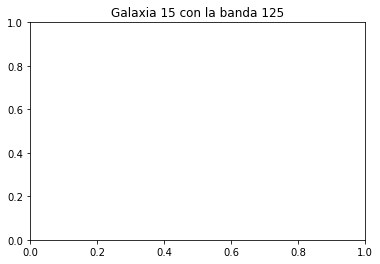

In [10]:
#Graficamos la galaxia_2 que corresponde a la número 15 con la banda 125 y el modo 'sci'
galaxia_2.imagen(15, 125, 'sci')

In [ ]:
galaxia_3 = Convoluciones(15, 125, 'sci', 435)

In [ ]:
galaxia_3.comparar(435)